In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv
/kaggle/input/playground-series-s3e2/sample_submission.csv
/kaggle/input/playground-series-s3e2/train.csv
/kaggle/input/playground-series-s3e2/test.csv


In [2]:
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('fivethirtyeight')

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LassoCV
import catboost as cb 
from scipy.stats import rankdata

In [3]:
train = pd.read_csv("/kaggle/input/playground-series-s3e2/train.csv", index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s3e2/test.csv', index_col='id')
submission = pd.read_csv('/kaggle/input/playground-series-s3e2/sample_submission.csv')

In [4]:
original = pd.read_csv("/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")

In [5]:
train_mean = train.mean()
original_mean = original.mean()

output_df = pd.DataFrame({'train': train_mean, 'original': original_mean})
print(output_df)

                       train      original
age                41.417708     43.226614
avg_glucose_level  89.039853    106.147677
bmi                28.112721     28.893237
heart_disease       0.023327      0.054012
hypertension        0.049726      0.097456
id                       NaN  36517.829354
stroke              0.041296      0.048728


/tmp/ipykernel_20/2872508846.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_mean = train.mean()
/tmp/ipykernel_20/2872508846.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  original_mean = original.mean()


In [6]:
train_Stroke_mean = train[train['stroke'] == 1].mean()
original_Stroke_mean = original[original['stroke'] == 1].mean()

stroke_out = pd.DataFrame({'train_Stroke': train_Stroke_mean, 'original_Stroke': original_Stroke_mean})
print(stroke_out)

                   train_Stroke  original_Stroke
age                   68.417722        67.728193
avg_glucose_level    107.362468       132.544739
bmi                   30.230696        30.471292
heart_disease          0.104430         0.188755
hypertension           0.202532         0.265060
id                          NaN     37115.068273
stroke                 1.000000         1.000000


/tmp/ipykernel_20/1191976017.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_Stroke_mean = train[train['stroke'] == 1].mean()
/tmp/ipykernel_20/1191976017.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  original_Stroke_mean = original[original['stroke'] == 1].mean()


In [7]:
train['Original'] = 0
test['Original'] = 0
original['Original'] = 1

In [8]:
train = pd.concat([train, original.query('stroke == 1').drop(columns=['id'], axis=1)], ignore_index=True)

In [9]:
train.isnull().sum()

gender                0
age                   0
hypertension          0
heart_disease         0
ever_married          0
work_type             0
Residence_type        0
avg_glucose_level     0
bmi                  40
smoking_status        0
stroke                0
Original              0
dtype: int64

In [10]:
dtr = DecisionTreeRegressor(random_state=42)

X = train[['age', 'gender', 'bmi']].copy()
X['gender'] = X['gender'].replace({
    'Male': 0,
    'Female': 1,
    'Other': -1
}).astype(np.int8)

Missing = X[X['bmi'].isna()]
X = X[~X['bmi'].isna()]
y = X.pop('bmi')
dtr.fit(X, y)
preds_bmi = pd.Series(dtr.predict(Missing[['age', 'gender']]), index=Missing.index)
train.loc[Missing.index, 'bmi'] = preds_bmi

In [11]:
df = pd.concat([train, test], axis=0)

In [12]:
df.nunique()

gender                  3
age                   109
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    4391
bmi                   465
smoking_status          4
stroke                  2
Original                2
dtype: int64

In [13]:
df['stroke'].sum() / len(df)

0.034204293978335985

In [14]:
df.groupby('gender')['stroke'].sum() / df.groupby('gender')['age'].count()

gender
Female    0.031962
Male      0.037843
Other     0.000000
dtype: float64

In [15]:
df['gender'].replace('Other', 'Female', inplace=True)
df = pd.concat([df, pd.get_dummies(df['gender'], drop_first=True)], axis=1)
df = df.drop(columns='gender', axis=1)

In [16]:
df['smoking_status'].value_counts()

never smoked       10608
Unknown             7566
formerly smoked     3991
smokes              3592
Name: smoking_status, dtype: int64

In [17]:
df['morbid'] = np.where(df['bmi']>40, 1, 0)
df['obese'] = np.where(df['bmi']>30, 1, 0)

In [18]:
def feature_risk_factors(df):
    df['risk_factors'] = df[['avg_glucose_level', 'age', 'bmi', 'hypertension', 'heart_disease', 'smoking_status']].apply(
        lambda x : 0 + (1 if x['avg_glucose_level'] > 99 else 0) +
        (1 if x['age'] > 45 else 0) + (1 if x['bmi'] > 24.99 else 0) +
        (1 if x['hypertension'] == 1 else 0) + (1 if x['heart_disease'] == 1 else 0) +
        (1 if x['smoking_status'] in ['formerly smoked', 'smokes'] else 0), 
        axis=1
    )
    return df

In [19]:
feature_risk_factors(df)

,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,Original,Male,morbid,obese,risk_factors
0,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0.0,0,1,0,1,1
1,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0.0,0,1,0,0,1
2,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0.0,0,0,1,1,2
3,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0.0,0,1,0,0,2
4,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25503,27.0,0,0,No,Private,Urban,75.77,17.6,never smoked,NaN,0,0,0,0,0
25504,49.0,0,0,Yes,Private,Urban,102.91,26.7,Unknown,NaN,0,1,0,0,3
25505,3.0,0,0,No,children,Rural,104.04,18.3,Unknown,NaN,0,0,0,0,1
25506,31.0,0,0,Yes,Private,Urban,82.41,28.7,never smoked,NaN,0,1,0,0,1


In [20]:
Age = df['age'].astype('int')
rate = []
for i in range(Age.min(), Age.max()):
    rate.append(df[Age < i]['stroke'].sum() / len(df[Age < i]['stroke']) * 100.0)

/tmp/ipykernel_20/254730299.py:4: RuntimeWarning: invalid value encountered in double_scalars
  rate.append(df[Age < i]['stroke'].sum() / len(df[Age < i]['stroke']) * 100.0)


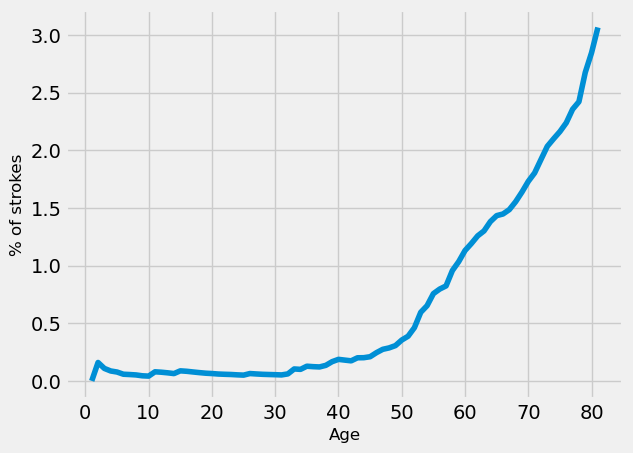

In [21]:
plt.plot(rate)
plt.xlabel('Age', fontsize=12)
plt.ylabel('% of strokes', fontsize=12)
plt.show()

In [22]:
df = pd.get_dummies(df)

In [23]:
scaler = StandardScaler()
num_cols = ['age', 'avg_glucose_level', 'bmi']
df[num_cols] = scaler.fit_transform(df[num_cols])

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25757 entries, 0 to 25507
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             25757 non-null  float64
 1   hypertension                    25757 non-null  int64  
 2   heart_disease                   25757 non-null  int64  
 3   avg_glucose_level               25757 non-null  float64
 4   bmi                             25757 non-null  float64
 5   stroke                          15553 non-null  float64
 6   Original                        25757 non-null  int64  
 7   Male                            25757 non-null  uint8  
 8   morbid                          25757 non-null  int64  
 9   obese                           25757 non-null  int64  
 10  risk_factors                    25757 non-null  int64  
 11  ever_married_No                 25757 non-null  uint8  
 12  ever_married_Yes                

In [25]:
X = df[:len(train)]
y = X['stroke']
X = X.drop(columns=['stroke', 'Original'], axis=1)

In [26]:
X_test = df.tail(len(test))
X_test = X_test.drop(columns=['stroke', 'Original'], axis=1)

In [27]:
X.shape, y.shape, X_test.shape

((15553, 22), (15553,), (10204, 22))

In [28]:
preds = []
scores = []

skf = StratifiedKFold(n_splits=20, random_state=42, shuffle=True)

model_params = {
    'precompute': 'auto',
    'fit_intercept': True,
    'max_iter': 100000,
    'verbose': False,
    'eps': 1e-04, 
    'n_alphas': 1000,
    'n_jobs': -1,
}

for train_index, test_index in skf.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = LassoCV(**model_params)
    
    model.fit(X_train, y_train)
    preds.append(model.predict(X_test))
    s = roc_auc_score(y_valid, model.predict(X_valid))
    print(f'Best val auc: {s: .4f}')
    scores.append(s)
    
print(f'mean scores: {np.mean(scores): .4f}')

Best val auc:  0.8441
Best val auc:  0.8184
Best val auc:  0.9230
Best val auc:  0.8674
Best val auc:  0.9077
Best val auc:  0.8527
Best val auc:  0.8313
Best val auc:  0.9133
Best val auc:  0.8621
Best val auc:  0.8895
Best val auc:  0.9268
Best val auc:  0.8955
Best val auc:  0.8909
Best val auc:  0.9010
Best val auc:  0.8809
Best val auc:  0.8713
Best val auc:  0.8528
Best val auc:  0.8700
Best val auc:  0.8588
Best val auc:  0.8311
mean scores:  0.8744


In [29]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [30]:
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

cb_params = {
    'depth': 3,
    'learning_rate': 0.01,
    'rsm': 0.5,
    'subsample': 0.931,
    'l2_leaf_reg': 69,
    'min_data_in_leaf': 20,
    'random_strength': 0.175,
    'use_best_model': True,
    'task_type': 'CPU',
    'bootstrap_type': 'Bernoulli',
    'grow_policy': 'SymmetricTree',
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'scale_pos_weight': 5
}

for train_index, val_index in skf.split(X, y):
    cb_train = cb.Pool(data=X.iloc[train_index], label=y.iloc[train_index])
    cb_valid = cb.Pool(data=X.iloc[val_index], label=y.iloc[val_index])
    
    model = cb.train(
        params=cb_params,
        dtrain=cb_train,
        num_boost_round=10000,
        evals=cb_valid, 
        early_stopping_rounds=500,
        verbose=False
    )
    
    s = roc_auc_score(y[val_index], model.predict(cb_valid))
    
    print(f"Best val auc: {s:.4f}")
    scores.append(s)
    preds.append(sigmoid(model.predict(X_test)))

print(f'mean scores: {np.mean(scores): .4f}')

Best val auc: 0.8726
Best val auc: 0.9045
Best val auc: 0.8971
Best val auc: 0.8974
Best val auc: 0.8802
Best val auc: 0.9243
Best val auc: 0.9133
Best val auc: 0.9030
Best val auc: 0.8853
Best val auc: 0.8719
mean scores:  0.8813


In [31]:
rankpreds = []

for pred in preds:
    rankpred = rankdata(pred)
    rankpreds.append(rankpred)

finalrank = np.average(np.array(rankpreds), axis=0) / len(X_test)

In [32]:
finalrank.shape

(10204,)

In [33]:
submission['stroke'] = finalrank
submission.to_csv('submission.csv', index=False)

In [34]:
submission.head(10)

,id,stroke
0,15304,0.715396
1,15305,0.947971
2,15306,0.220280
3,15307,0.719189
4,15308,0.378374
5,15309,0.320164
6,15310,0.506724
7,15311,0.840987
8,15312,0.255370
9,15313,0.583031
